In [1]:
import torch
if torch.cuda.is_available():
    print("GPU is available!")
    print("Device Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available.")

GPU is available!
Device Name: Tesla T4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 11.8 MB/s eta 0:00:00


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.



--- Setting up Model 1: Standard PINN (PDE + Data) ---
Compiling model...
'compile' took 5.896792 s


--- Setting up Model 2: PINN with Angular Momentum ---
Compiling model...
'compile' took 0.000180 s


--- Setting up Model 3: PINN with Ang. Mom. and Full ICs ---
Compiling model...
'compile' took 0.000125 s


--- Training Standard_PINN ---
Training model...

Step      Train loss                                  Test loss                                   Test metric                                 
0         [4.80e+09, 2.78e+09, 8.75e+01, 4.23e+01]    [3.04e+10, 1.76e+10, 8.75e+01, 4.23e+01]    [1.41e+00, 1.41e+00, 1.41e+00, 1.41e+00]    


/usr/local/lib/python3.11/dist-packages/torch/utils/_device.py:104: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return func(*args, **kwargs)


2000      [2.93e+00, 4.75e-01, 1.94e+02, 1.52e+02]    [2.37e+00, 3.87e-01, 1.94e+02, 1.52e+02]    [1.36e+00, 1.52e+00, 1.55e+00, 1.65e+00]    
4000      [2.93e+00, 4.75e-01, 1.94e+02, 1.52e+02]    [2.37e+00, 3.87e-01, 1.94e+02, 1.52e+02]    [1.36e+00, 1.52e+00, 1.55e+00, 1.65e+00]    
6000      [2.94e+00, 4.75e-01, 1.94e+02, 1.52e+02]    [2.37e+00, 3.87e-01, 1.94e+02, 1.52e+02]    [1.36e+00, 1.52e+00, 1.55e+00, 1.65e+00]    
8000      [2.94e+00, 4.75e-01, 1.94e+02, 1.51e+02]    [2.37e+00, 3.87e-01, 1.94e+02, 1.51e+02]    [1.36e+00, 1.52e+00, 1.55e+00, 1.65e+00]    
10000     [2.96e+00, 4.75e-01, 1.94e+02, 1.50e+02]    [2.39e+00, 3.87e-01, 1.94e+02, 1.50e+02]    [1.36e+00, 1.52e+00, 1.55e+00, 1.65e+00]    
12000     [3.00e+00, 4.76e-01, 1.91e+02, 1.46e+02]    [2.42e+00, 3.87e-01, 1.91e+02, 1.46e+02]    [1.36e+00, 1.52e+00, 1.55e+00, 1.65e+00]    
14000     [3.14e+00, 4.79e-01, 1.85e+02, 1.36e+02]    [2.53e+00, 3.90e-01, 1.85e+02, 1.36e+02]    [1.36e+00, 1.52e+00, 1.54e+00, 1.64e+00]    

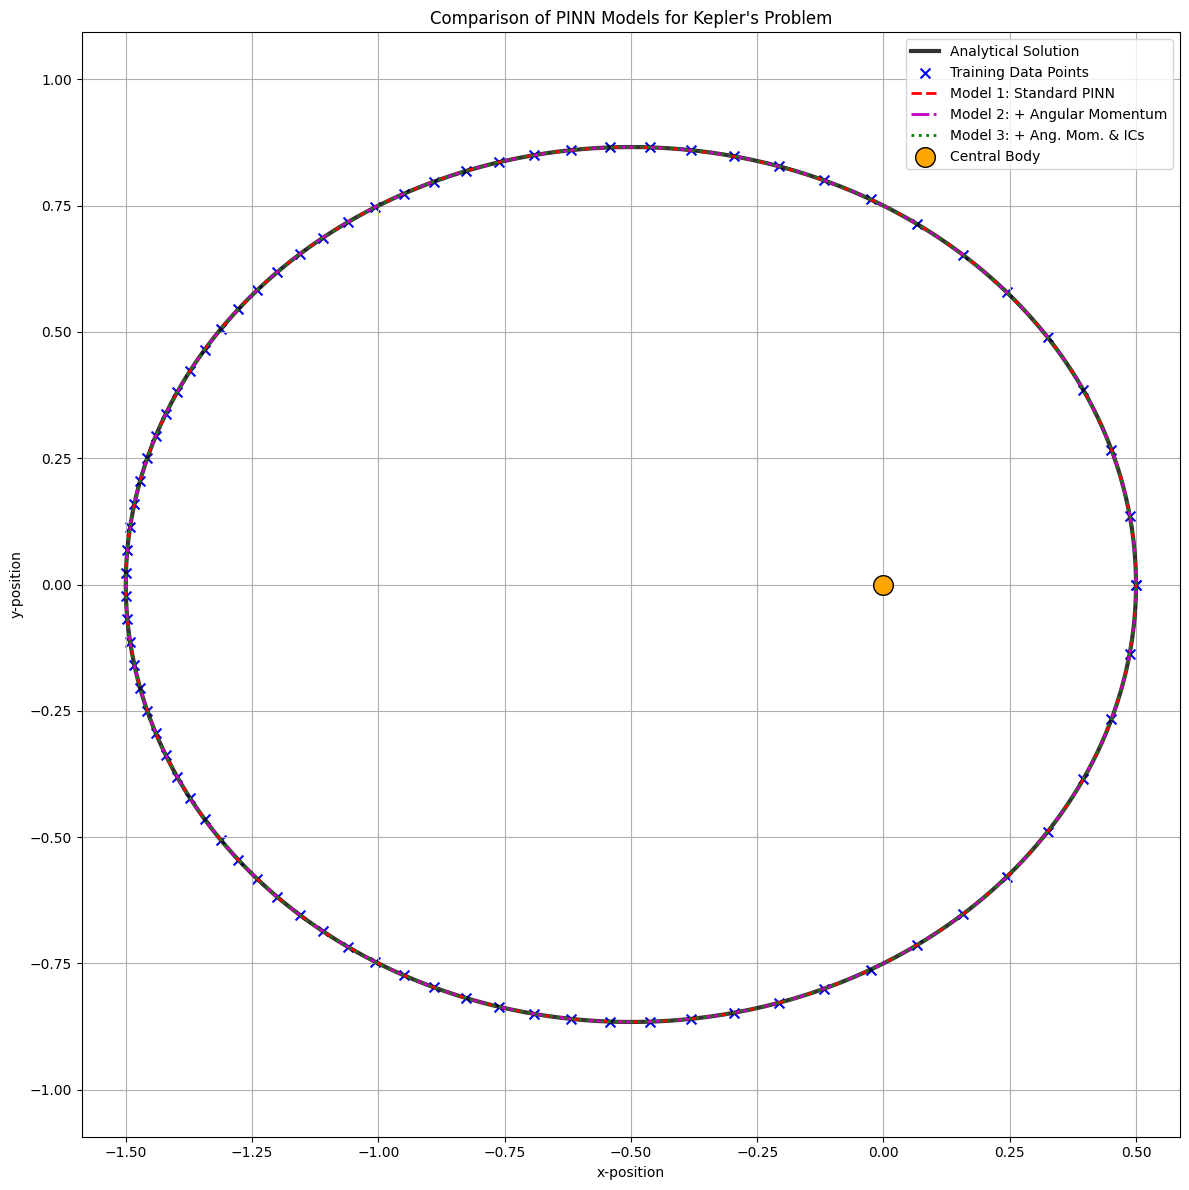

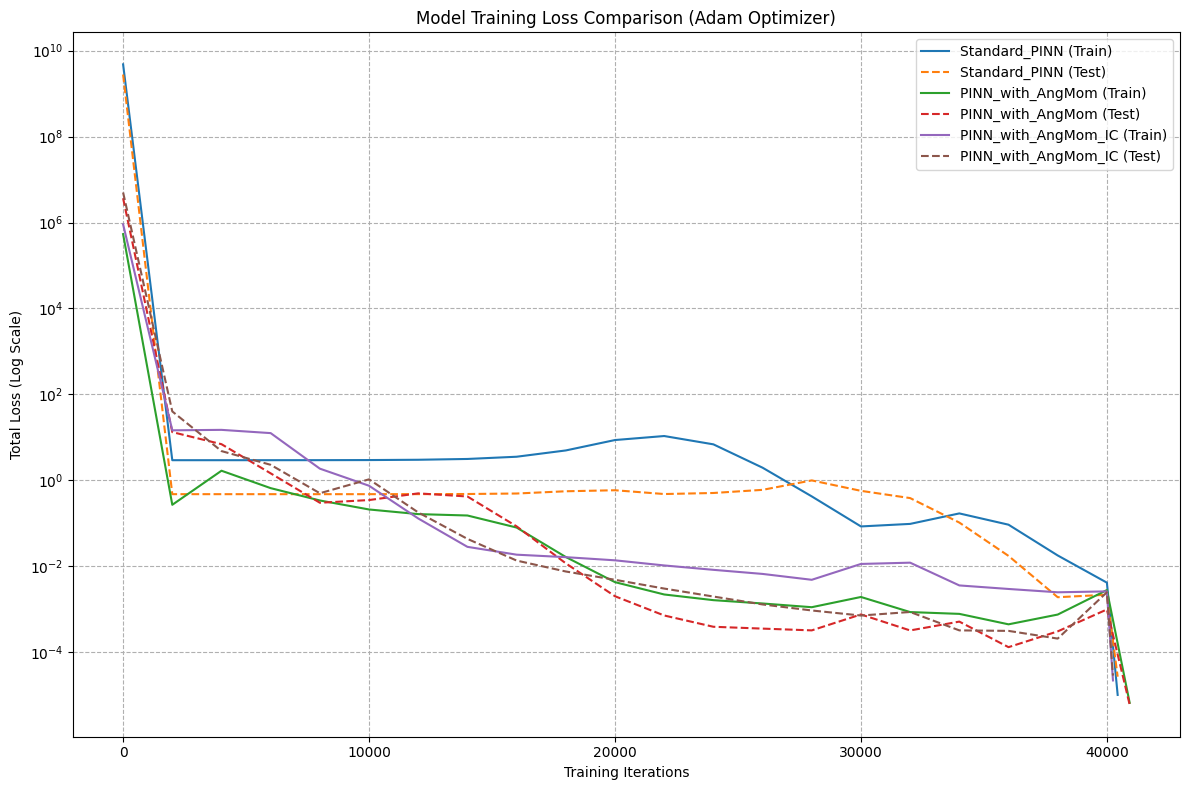

In [2]:
# Install deepxde if you haven't already
!pip install deepxde

import numpy as np
import torch
import matplotlib.pyplot as plt

import os
os.environ['DDE_BACKEND'] = 'pytorch'

import deepxde as dde

# --- 1. Problem Setup and Analytical Data Generation ---

# Physical constants for the Kepler problem
MU = 1.0  # Standard gravitational parameter (G*M)
a = 1.0   # Semi-major axis
e = 0.5   # Eccentricity
T = 2 * np.pi * np.sqrt(a**3 / MU) # Orbital period from Kepler's Third Law

def solve_kepler(M, e, tol=1e-9):
    """
    Solves Kepler's equation M = E - e*sin(E) for the eccentric anomaly E,
    given the mean anomaly M and eccentricity e.
    Uses the Newton-Raphson iterative method.
    """
    E = M
    for _ in range(100):
        f = E - e * np.sin(E) - M
        f_prime = 1 - e * np.cos(E)
        E_new = E - f / f_prime
        if np.all(np.abs(E_new - E) < tol):
            return E_new
        E = E_new
    return E

def get_analytical_solution(t, a, e, mu):
    """
    Computes the analytical solution (position and velocity) for the 2D Kepler problem
    at a given time `t` or array of times.
    """
    M = np.sqrt(mu / a**3) * t
    E = solve_kepler(M, e)
    x_orb = a * (np.cos(E) - e)
    y_orb = a * np.sqrt(1 - e**2) * np.sin(E)
    edot = np.sqrt(mu / a**3) / (1 - e * np.cos(E))
    vx_orb = -a * np.sin(E) * edot
    vy_orb = a * np.sqrt(1 - e**2) * np.cos(E) * edot
    return x_orb, y_orb, vx_orb, vy_orb

# Define the computational domain: time from 0 to one full period T
t_start, t_end = 0, T
geom = dde.geometry.TimeDomain(t_start, t_end)

# --- 2. Define the Physics-Informed Residuals ---

def pde_system(t, u):
    """
    Defines the governing differential equations for Kepler's problem (Newton's law of gravitation).
    This function must use backend-compatible operations.
    """
    x, y = u[:, 0:1], u[:, 1:2]
    ax = dde.grad.hessian(u, t, component=0, i=0, j=0)
    ay = dde.grad.hessian(u, t, component=1, i=0, j=0)

    r_sq = x**2 + y**2

    epsilon = torch.tensor(1e-8, dtype=t.dtype, device=t.device)
    mu_tensor = torch.tensor(MU, dtype=t.dtype, device=t.device)

    r = (r_sq + epsilon)**0.5

    res_x = ax + mu_tensor * x / (r**3)
    res_y = ay + mu_tensor * y / (r**3)

    return [res_x, res_y]

# Calculate initial specific angular momentum (h0).
x0_val_arr, y0_val_arr, vx0_val_arr, vy0_val_arr = get_analytical_solution(np.array([t_start]), a, e, MU)
h0 = float((x0_val_arr * vy0_val_arr - y0_val_arr * vx0_val_arr)[0])

def angular_momentum_residual(t, u):
    """
    Defines the residual for the conservation of specific angular momentum (h).
    """
    x, y = u[:, 0:1], u[:, 1:2]
    vx = dde.grad.jacobian(u, t, i=0, j=0)
    vy = dde.grad.jacobian(u, t, i=1, j=0)
    h = x * vy - y * vx
    h0_tensor = torch.tensor(h0, dtype=t.dtype, device=t.device)
    return h - h0_tensor

# --- 3. Generate Training Data & Define Boundary/Initial Conditions ---

n_data = 80
t_data = np.linspace(t_start, t_end, n_data).reshape(-1, 1)
x_true, y_true, _, _ = get_analytical_solution(t_data, a, e, MU)
training_data_plot = np.hstack((x_true, y_true))

observe_x = dde.PointSetBC(t_data, x_true, component=0)
observe_y = dde.PointSetBC(t_data, y_true, component=1)

x0, y0, vx0, vy0 = float(x0_val_arr[0]), float(y0_val_arr[0]), float(vx0_val_arr[0]), float(vy0_val_arr[0])

ic_pos_x = dde.IC(geom, lambda t: x0, lambda _, on_initial: on_initial, component=0)
ic_pos_y = dde.IC(geom, lambda t: y0, lambda _, on_initial: on_initial, component=1)
ic_vel_x = dde.OperatorBC(geom, lambda t, u, _: dde.grad.jacobian(u, t, i=0, j=0) - vx0, lambda _, on_initial: on_initial)
ic_vel_y = dde.OperatorBC(geom, lambda t, u, _: dde.grad.jacobian(u, t, i=1, j=0) - vy0, lambda _, on_initial: on_initial)

bcs_data_only = [observe_x, observe_y]
bcs_full = [observe_x, observe_y, ic_pos_x, ic_pos_y, ic_vel_x, ic_vel_y]

# --- 4. Model Definition, Compilation, and Training ---

def create_fnn():
    """Creates a standard Feedforward Neural Network for the models."""
    return dde.nn.FNN([1] + [64] * 4 + [2], "tanh", "Glorot normal")

def combined_physics_model(t, u):
    pde_res = pde_system(t, u)
    ang_mom_res = angular_momentum_residual(t, u)
    return pde_res + [ang_mom_res]

solution_fn = lambda t: get_analytical_solution(t, a, e, MU)

# Define the metric to be used, which is the L2 relative error.
# This serves as a normalized Root Mean Squared Error (RMSE).
metrics = ["l2 relative error"]

# --- Model 1: Standard PINN (PDE + Data) ---
print("\n--- Setting up Model 1: Standard PINN (PDE + Data) ---")
data1 = dde.data.PDE(geom, pde_system, bcs_data_only, num_domain=500, num_boundary=2, solution=solution_fn, num_test=1000)
model1 = dde.Model(data1, create_fnn())
loss_weights1 = [1, 1, 100, 100]
model1.compile("adam", lr=1e-3, loss_weights=loss_weights1, metrics=metrics)

# --- Model 2: PINN with Angular Momentum (PDE + Data + Ang. Mom.) ---
print("\n--- Setting up Model 2: PINN with Angular Momentum ---")
data2 = dde.data.PDE(geom, combined_physics_model, bcs_data_only, num_domain=500, num_boundary=2, solution=solution_fn, num_test=1000)
model2 = dde.Model(data2, create_fnn())
loss_weights2 = [1, 1, 10, 100, 100]
model2.compile("adam", lr=1e-3, loss_weights=loss_weights2, metrics=metrics)

# --- Model 3: PINN with Ang. Mom. and Full Initial Conditions ---
print("\n--- Setting up Model 3: PINN with Ang. Mom. and Full ICs ---")
data3 = dde.data.PDE(geom, combined_physics_model, bcs_full, num_domain=500, num_boundary=2, solution=solution_fn, num_test=1000)
model3 = dde.Model(data3, create_fnn())
loss_weights3 = [1, 1, 10, 100, 100, 100, 100, 100, 100]
model3.compile("adam", lr=1e-3, loss_weights=loss_weights3, metrics=metrics)

# --- Training Loop ---
models_to_train = {
    "Standard_PINN": (model1, loss_weights1),
    "PINN_with_AngMom": (model2, loss_weights2),
    "PINN_with_AngMom_IC": (model3, loss_weights3)
}
predictions = {}


for name, (model, weights) in models_to_train.items():
    print(f"\n--- Training {name} ---")
    if not os.path.exists(name):
        os.makedirs(name)

    losshistory, train_state = model.train(iterations=40000, display_every=2000)

    print(f"--- Refining {name} with L-BFGS ---")
    model.compile("L-BFGS", loss_weights=weights, metrics=metrics) # Re-compile for L-BFGS
    losshistory, train_state = model.train()

    dde.saveplot(losshistory, train_state, issave=True, isplot=False, output_dir=name)

    t_pred_domain = np.linspace(t_start, t_end, 500).reshape(-1, 1)
    predictions[name] = model.predict(t_pred_domain)

# --- 5. Final Comparison Plot ---
print("\n--- Generating final comparison plot ---")
t_plot = np.linspace(t_start, t_end, 500)
x_true_plot, y_true_plot, _, _ = get_analytical_solution(t_plot, a, e, MU)

plt.figure(figsize=(12, 12))
plt.plot(x_true_plot, y_true_plot, 'k-', label='Analytical Solution', linewidth=3, alpha=0.8)
plt.scatter(training_data_plot[:, 0], training_data_plot[:, 1], c='blue', marker='x', s=50, label="Training Data Points")

pred1 = predictions["Standard_PINN"]
pred2 = predictions["PINN_with_AngMom"]
pred3 = predictions["PINN_with_AngMom_IC"]
plt.plot(pred1[:, 0], pred1[:, 1], 'r--', label='Model 1: Standard PINN', linewidth=2)
plt.plot(pred2[:, 0], pred2[:, 1], 'm-.', label='Model 2: + Angular Momentum', linewidth=2)
plt.plot(pred3[:, 0], pred3[:, 1], 'g:', label='Model 3: + Ang. Mom. & ICs', linewidth=2)

plt.scatter([0], [0], s=200, c='orange', marker='o', edgecolors='black', label="Central Body", zorder=5)

plt.title("Comparison of PINN Models for Kepler's Problem")
plt.xlabel("x-position")
plt.ylabel("y-position")
plt.legend(loc='upper right')
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.savefig("final_comparison_orbit.png")

# --- Loss History Plot ---
print("\n--- Generating final comparison plot for loss history ---")
plt.figure(figsize=(12, 8))
# Read and plot loss history from .dat files
for name in models_to_train.keys():
    try:
        loss_data = np.loadtxt(os.path.join(name, "loss.dat"))
        steps = loss_data[:, 0]
        train_loss = loss_data[:, 1]
        test_loss = loss_data[:, 2]
        plt.plot(steps, train_loss, label=f'{name} (Train)')
        plt.plot(steps, test_loss, label=f'{name} (Test)', linestyle='dashed')
    except FileNotFoundError:
        print(f"Loss history file not found for {name}. Skipping plot.")


plt.yscale('log')
plt.title('Model Training Loss Comparison (Adam Optimizer)')
plt.xlabel('Training Iterations')
plt.ylabel('Total Loss (Log Scale)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.savefig("final_comparison_loss.png")

# Show all generated figures.
plt.show()